In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "7"

In [2]:
import torch
from datasets import load_dataset

from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.trainers import WordLevelTrainer
from tokenizers.pre_tokenizers import Whitespace
import os
from dataloader.dataloader import NMTDataset
from torch.utils.data import DataLoader
from models.transformer import Transformer
from torchsummary import torchsummary
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchmetrics import ExactMatch, Accuracy

device = torch.device("cuda")
cpu_device = torch.device("cpu")

%reload_ext autoreload
%autoreload 2

/data3/home/karmpatel/miniconda3/envs/torch310/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
n_train = 6000
train_dataset = load_dataset('cfilt/iitb-english-hindi', split=f"train[:{n_train}]")
print(len(train_dataset))

test_dataset = load_dataset('cfilt/iitb-english-hindi', split="test")
print(len(test_dataset))

val_dataset = load_dataset('cfilt/iitb-english-hindi', split="validation")
print(len(val_dataset))

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=len(train_dataset))
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=len(val_dataset))
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset))

tr = next(iter(train_dataloader))
vl = next(iter(val_dataloader))
tt = next(iter(test_dataloader))

Repo card metadata block was not found. Setting CardData to empty.


6000


Repo card metadata block was not found. Setting CardData to empty.


2507


Repo card metadata block was not found. Setting CardData to empty.


520


In [4]:
for lang in ["hi", "en"]:
    tokenizer_path = f"dataset/vocab_{lang}_{n_train}.json"
    if os.path.exists(tokenizer_path):
        # load tokenizer
        tokenizer = Tokenizer.from_file(tokenizer_path)
    else:
        tokenizer = Tokenizer(WordLevel(unk_token="<unk>"))
        tokenizer.pre_tokenizer = Whitespace()
        trainer = WordLevelTrainer(special_tokens=['<unk>', '<pad>', '<sos>', '<eos>'], min_frequency=2)
        tokenizer.train_from_iterator(tr['translation'][lang] + vl['translation'][lang]+ tt['translation'][lang], trainer=trainer)

        # save tokenizer
        tokenizer.save(tokenizer_path)


tokenizer_src = Tokenizer.from_file(f"dataset/vocab_en_{n_train}.json")
tokenizer_tar = Tokenizer.from_file(f"dataset/vocab_hi_{n_train}.json")
tokenizer_tar

In [5]:
train_ds = NMTDataset(tokenizer_src, tokenizer_tar, train_dataloader)
val_ds = NMTDataset(tokenizer_src, tokenizer_tar, val_dataloader)
print(len(train_ds), len(val_ds))

6000 520


In [6]:
B = 512
train_dl = DataLoader(train_ds, batch_size=B, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=len(val_ds), shuffle=True)

In [7]:
seq_len = 100
d_model = 512
drop_prob = 0.1
n_h = 8
d_ff = 2048
d_k = d_model/n_h
n_layers = 6

transformer = Transformer(tokenizer_src.get_vocab_size(), tokenizer_tar.get_vocab_size(), d_model, n_h, n_layers , d_ff, seq_len, drop_prob, tokenizer_src.token_to_id("<pad>"), tokenizer_tar.token_to_id("<pad>")).to(device)

In [8]:
# torchsummary.summary(transformer, [(1, 100), (1, 100)], device="cpu")

### Train loop

In [9]:
import torch.nn.functional as F
import torch.nn as nn

In [10]:
lr = 1e-4
optim = torch.optim.Adam(transformer.parameters(),lr=lr)
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=tokenizer_src.token_to_id('<pad>'))
EM = ExactMatch(task="multiclass", num_classes=tokenizer_tar.get_vocab_size(), 
                ignore_index=tokenizer_tar.token_to_id("<pad>")).to(device)
Acc = Accuracy(task="multiclass", num_classes=tokenizer_tar.get_vocab_size(), 
                ignore_index=tokenizer_tar.token_to_id("<pad>")).to(device)

In [11]:
n_epochs = 3

train_losses, val_losses = [], []
val_ems, val_accs = [], []
prev_loss = 1e4
for i in range(n_epochs):
    transformer.train()
    tqdm_obj = tqdm(train_dl)
    for src, tar in tqdm_obj:
        src, tar = src.to(device), tar.to(device)
        optim.zero_grad()
        logits = transformer(src, tar)
        y_pred = torch.argmax(logits, dim=-1)
        loss = loss_fn(logits.permute(0,2,1), tar)
        loss.backward()
        optim.step()
        train_losses.append(loss.detach().to(cpu_device))
        tqdm_obj.set_description_str(f"Epoch {i+1}/{n_epochs} train loss - {loss.detach().to(cpu_device)}")
    
    
    with torch.no_grad():
        transformer.eval()
        src, tar = next(iter(val_dl))
        src, tar = src.to(device), tar.to(device)
        val_logits = transformer(src, tar)
        val_y_pred = torch.argmax(val_logits, dim=-1)
        val_loss = loss_fn(val_logits.permute(0,2,1), tar)
        val_losses.append(val_loss.detach().to(cpu_device))
        
        val_acc, val_em = Acc(val_y_pred, tar).to(cpu_device), EM(val_y_pred, tar).to(cpu_device)
        val_accs.append(val_acc)
        val_ems.append(val_em)
        if val_loss < prev_loss:
            print("Saving Model -", end=" ")
            torch.save(transformer.state_dict(), f"ckpts/test_transformer_{n_train}_{lr}")            
        prev_loss = val_loss
        
    print(f"Val loss: {val_loss.detach().to(cpu_device)} Val acc {val_acc} Val EM {val_em}") 

Epoch 1/3 train loss - 4.440422058105469: 100%|██████████████████████████████████████| 12/12 [00:20<00:00,  1.71s/it]


Saving Model - Val loss: 6.654748916625977 Val acc 0.25666874647140503 Val EM 0.0


Epoch 2/3 train loss - 2.7716526985168457: 100%|█████████████████████████████████████| 12/12 [00:19<00:00,  1.66s/it]


Saving Model - Val loss: 5.752293109893799 Val acc 0.3809438943862915 Val EM 0.0


Epoch 3/3 train loss - 1.879019021987915: 100%|██████████████████████████████████████| 12/12 [00:14<00:00,  1.19s/it]


Saving Model - Val loss: 5.184224605560303 Val acc 0.4507092535495758 Val EM 0.0


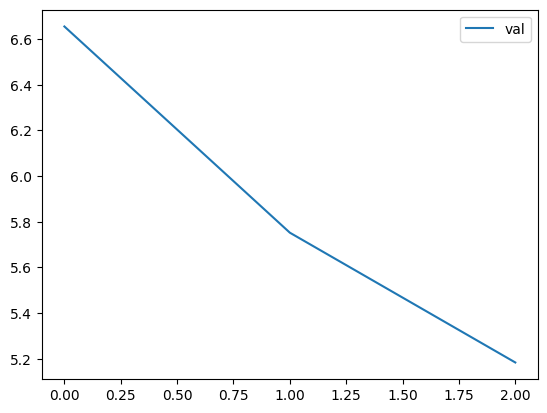

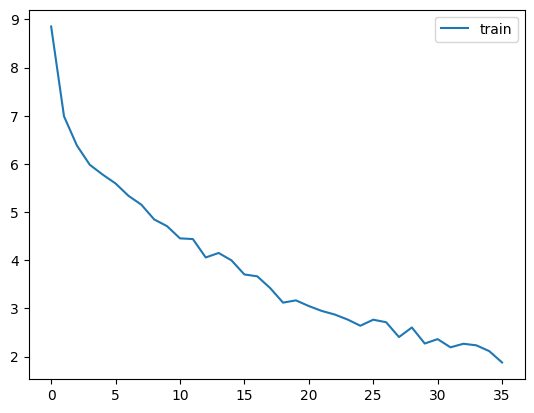

In [12]:
plt.figure()
plt.plot(val_losses, label="val")
plt.legend()
plt.savefig(f"plots/val_loss_{n_train}")

plt.figure()
plt.plot(train_losses, label="train")
plt.legend()
plt.savefig(f"plots/train_loss_{n_train}.pdf")

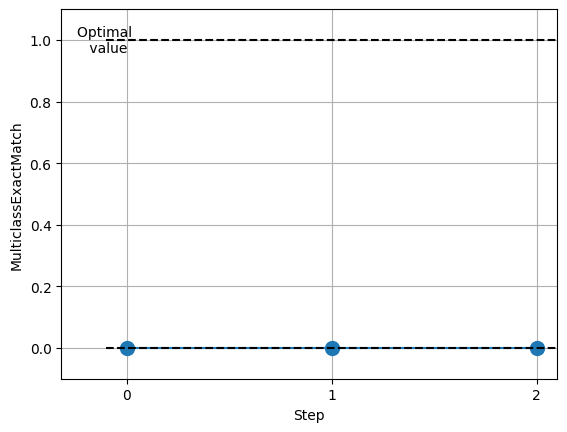

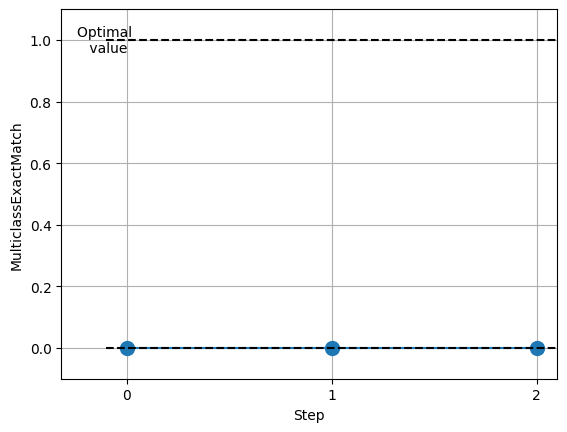

In [13]:
fig, ax = EM.plot(val_ems)
fig.savefig(f"plots/EM_{n_train}.pdf")
fig

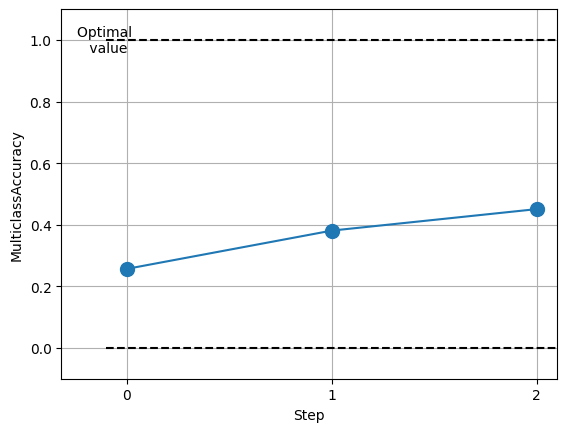

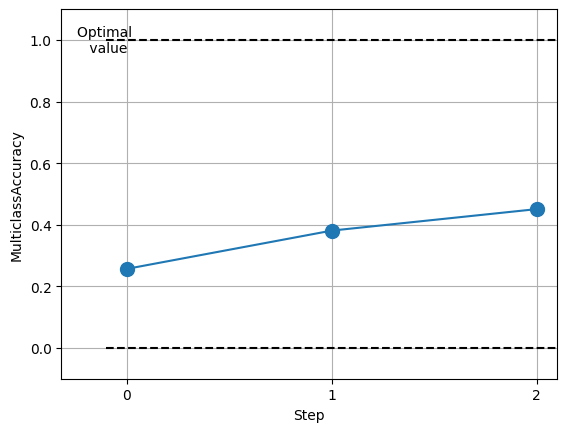

In [14]:
fig, ax = Acc.plot(val_accs)
fig.savefig(f"plots/Acc_{n_train}.pdf")
fig

In [115]:
src = next(iter(train_dl))[0]
tar = next(iter(train_dl))[1]
logits = transformer(src, tar)
logits.shape

torch.Size([512, 100, 7127])

In [116]:
log_probs = F.log_softmax(logits, dim=-1)

In [117]:
y_pred = torch.argmax(logits, dim=-1)
y_pred.shape, y_pred[0]

(torch.Size([512, 100]),
 tensor([5064, 4260, 4499,  606, 6286,  397, 2506,  133, 6286, 3653, 1399,  181,
          133,  397,   66, 6286,  397,  397,  397,  397,  397,  397, 6286,  133,
          181,  397,  133, 6286, 6286, 6286,  397,  397, 2979,  397,  397, 3603,
          397,  181, 3603, 6286, 3603, 6286, 5191,  133,  133, 5191,  397,  397,
          397, 3129,  397, 6327, 6286, 1399,  397, 6286, 6286,  181,  133, 6286,
         4614,  397,  397,  397, 2506,  133, 6760, 3129,  397,  397,  145, 6866,
          181,  133,  181, 3603,  181,  181,  181,  515,  181, 5191, 2884,  133,
         5191,  397, 1916,  133, 5191,  133, 5527, 6327,  133,  133, 5527,  133,
          397, 5527, 6743, 5191]))

In [120]:
loss_fn(logits.permute(0,2,1), tar)

tensor(8.9751, grad_fn=<NllLoss2DBackward0>)